<a href="https://colab.research.google.com/github/ZohebAbai/mobile_sensing_robotics/blob/main/Visual_Features_RANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3 - Visual Features and RANSAC

In this exercise, you will implement a visual feature detector and descriptor to find correspondences/matches between two images together. You will then use these matches to stich these images together within a RANSAC routine to deal with outliers. 

**To save time and resources, we will use opencv functions instead of creating functions from scratch.**

**Upgrade OpenCV version in Colab**

In [ ]:
!pip install --upgrade opencv-python

In [2]:
import cv2
print(cv2.__version__)

4.5.2


## 3.1 Implement a feature detector [5.0]

Your goal is to implement a feature detector as explained in the lecture. Implement both the Harris-Corner detector and Shi-Tomasi corner criteria  in the function. Implement the ``compute_corners`` function. It takes as input:

    I : float [MxN] 
        grayscale image

    type :  string
            corner type ('harris' or 'Shi-Tomasi')

    T:  float
        threshold for corner detection
    
and returns:

    corners : numpy array [num_corners x 2] 
              Coordinates (x,y) of the detected corners.    

Test your implementation on the 'checkerboard.jpg' image and verify that the detections are correct.

** Hints **: 

1. You may use 'ndimage.convolve' function from the scipy library to perform 2D convolution.



Text(0.5, 0, 'Shi-Tomasi Corners')

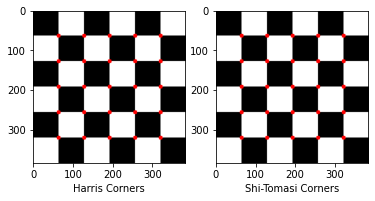

In [1]:
import numpy as np
import cv2
import imageio
import imutils
import matplotlib.pyplot as plt
import ex6

# read images and transform them to grayscale
I_checkerboard = cv2.imread('checkerboard.png')
# Convert to grayscale
I_checkerboard_gray = cv2.cvtColor(I_checkerboard, cv2.COLOR_BGR2GRAY)

# compute corners and visualize them on top of the image
corners_harris = ex6.compute_corners(I_checkerboard_gray, 'harris')
corners_shi_tomasi = ex6.compute_corners(I_checkerboard_gray, 'shi-tomasi')

# Visualize the detections by plotting them over the image
fig = plt.figure()
plt.subplot(1,2,1)
# Iterate through all the corners and draw them on the image 
for i in corners_harris:
    x,y = i.ravel()
    cv2.circle(I_checkerboard, (x,y), 5, 255, -1)
plt.imshow(I_checkerboard)
plt.xlabel("Harris Corners")

plt.subplot(1,2,2)
for i in corners_shi_tomasi:
    x,y = i.ravel()
    cv2.circle(I_checkerboard, (x,y), 5, 255, -1)
plt.imshow(I_checkerboard)
plt.xlabel("Shi-Tomasi Corners")

## 3.2 Compute a feature descriptor [5.0]

The next task is to implement a feature descriptor as explained in the lecture. The descriptor for each keyppoint should 128 bits. Implement the ``compute_descriptors`` function. It takes as input:

    I : float [MxN]
        grayscale image as a 2D numpy array
    corners : numpy array [num_corners x 2] 
              Coordinates of the detected corners. 
    
and returns:

    D : numpy array [num_corners x 128]
        128 bit descriptors  corresponding to each corner keypoint

Test your implementation on the 'checkerboard.jpg' image.

** Hints **: 

1. You may use think of re-using the gradient information from ``compute_corners`` for computing descriptors.

**Image Source:**
"Github: daeyun Image-Stitching Test Images", 2016. [Online]. Available: https://github.com/daeyun/Image-Stitching/tree/master/img/hill.

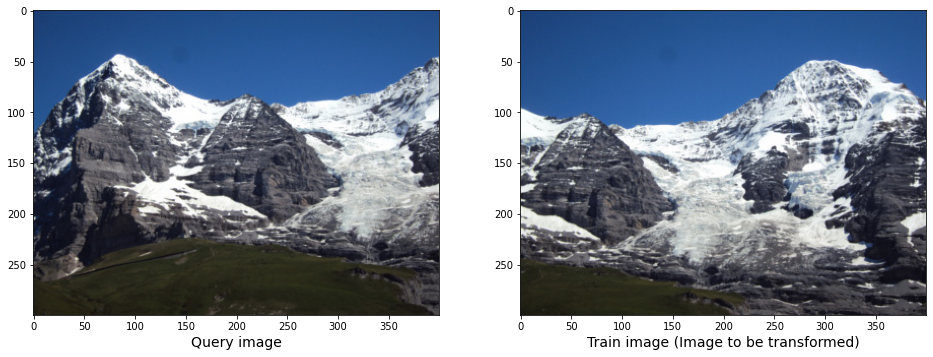

In [2]:
# read images and transform them to grayscale
queryImg = imageio.imread('mountain_1.jpeg')
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

# Make sure that the train image is the image that will be transformed
trainImg = imageio.imread('mountain_2.jpeg')
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [3]:
# compute the keypoints and feature descriptor for the two images 
kps1, features1 = ex6.compute_descriptors(queryImg_gray, method = 'orb')
kps2, features2 = ex6.compute_descriptors(trainImg_gray, method = 'orb')

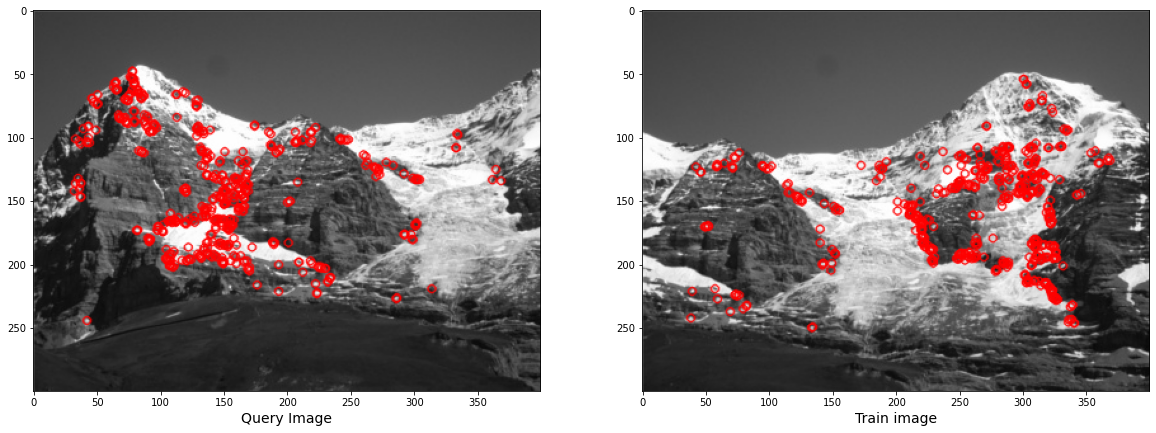

In [4]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(queryImg_gray, kps1, None, color=(255,0,0)))
ax1.set_xlabel("Query Image", fontsize=14)
ax2.imshow(cv2.drawKeypoints(trainImg_gray, kps2, None, color=(255,0,0)))
ax2.set_xlabel("Train image", fontsize=14)

plt.show()

## 3.3 Compute correspondences for the images [5.0]

Now, the goal is to compute correspondences (matches) between two images based on the descriptors computed in the previous task. The descriptors can be compared by computing a score in a one vs all fashion, and a match should be accepted if it meets the Lowe's critera as described in the lecture. 

Implement the function `compute_matches`. It takes as input:
    
    D1 : numpy array [num_corners x 128]
         descriptors for image 1 keypoints
    
    D2 : numpy array [num_corners x 128]
         descriptors for image 2 keypoints

and returns

    M : numpy array [num_matches x 2]
        [cornerIdx1, cornerIdx2] each row contains indices of corresponding keypoints from each image.

Test your implementation on the images used in the previous task and visualize the matches. 

Raw matches (knn): 500


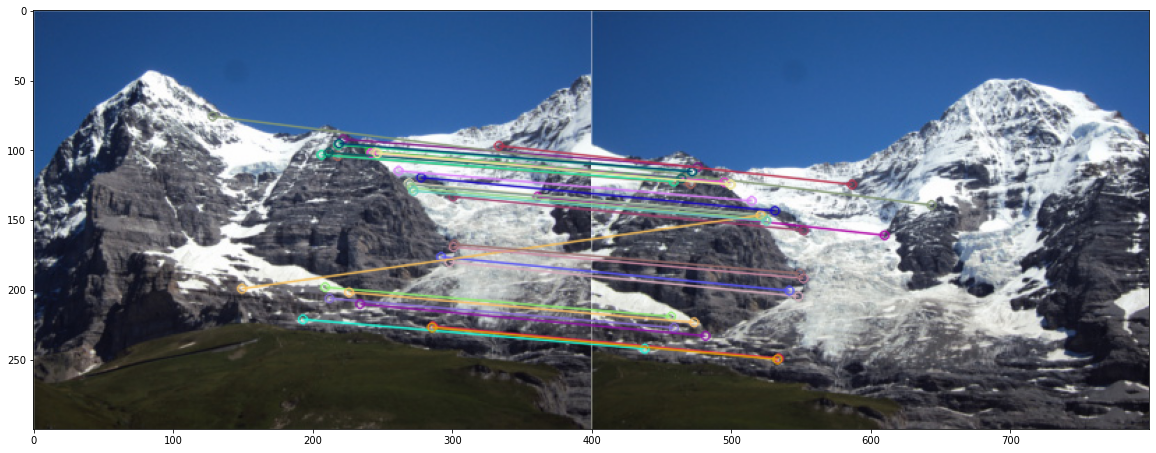

In [5]:
# Matches for harris corner keypoints and corresponding keypoints
matches = ex6.compute_matches(features1, features2)

# Visualize the matches
fig = plt.figure(figsize=(20,8))
img_match = cv2.drawMatches(queryImg, kps1, trainImg, kps2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_match)
plt.show()

## 3.4 Application: Image Stiching [5.0]

In this part of the assignment, the goal is to stitch two images (which we have used in the previous tasks) together. To stitch these images, we first need to compute a transformation (also called as Homography) between these two images. We will use the matches computed in the previous step to compute the homography.

The matches computed by matching the descriptors usually contain outliers which are bad correspondences. In this task, we want to estimate the transformation (Homography) between the two image despite the presence of outliers in the matches. In order to achieve this, you have to implement a RANSAC based algorithm which estimates the homography and the set of inlier matches. 

In order to implement the algorithm, you will need to: 
  - For each iteration, randomly choose four feature matches in all found matches in function **compute_homography_ransac()**;
  - Estimate a homography using 4 corresponding points in two images in function **comute_homography_four_matches()**. This function has already been implemented for you. 
  - Calculate the geometric distance (error) betweeen the transformed points from first image and the corresponding points in the second image, namely residuals, in function **compute_residual()**;
  - Check all matches with estimated homography matrix and label inliers based on the 'max_inlier_thres' in function **compute_homography_ransac()**;
  - Terminate the procedure if a homography is found which satisfies the inliers codition or exceeds the maximum number iterations the in function **compute_homography_ransac()**.

Refer to the lecture slides for all the details.  After you have implemented all the above, you should have an good estimated homography matrix.

In [6]:
H, M = ex6.compute_homography_ransac(kps1, kps2, matches)
print(H)

[[ 1.15590152e+00 -6.65832977e-02 -1.68113952e+02]
 [ 1.22974396e-01  1.07998973e+00 -4.82875469e+00]
 [ 4.35826768e-04 -9.55052395e-05  1.00000000e+00]]


## 3.5 Application: Image stiching [5.0]

Use the estimated homography matrix to stitch and plot two images in one figure.

**Hint:** The **warpPerspective** functions of **OpenCV** library can be useful in this task.

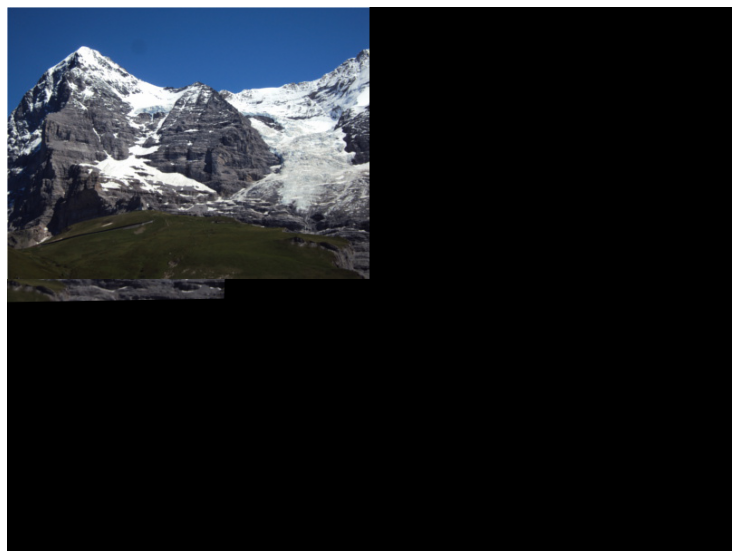

In [7]:
# Apply panorama correction
width = queryImg.shape[1] + trainImg.shape[1] 
height = queryImg.shape[0] + trainImg.shape[0] 

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

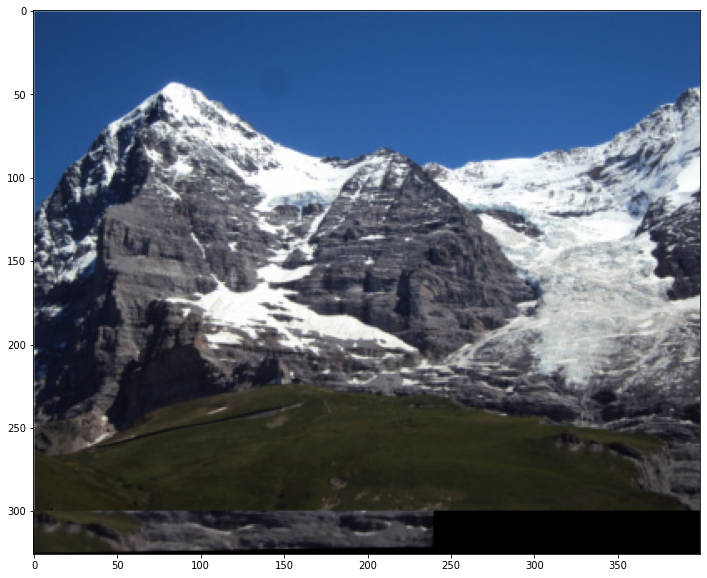

In [9]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)